In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import r2_score

# Notebook for comparing regressions of ln(k) vs ln(t) from real vs random k data

Notebook to:
- Do some general exploring of the Catalan et al. (2016) data
- Compare regressions of ln(k) vs ln(t) using real k values from Catalan et al. (2016), as well as randomly-generated k values

# Read in data and add random DOC transmission data

In [20]:
# Read in data
data_fpath = r'data/catalan_2016_doc_data.xlsx'
df_full = pd.read_excel(data_fpath, usecols='A:M')

df_full.rename({'WRT (years) ': 'tau',
          'Degradation rate temperature corrected (d-1)': 'k_per_day',
          'FieldII': 'Method',
          'System10': 'System'},
          axis='columns', inplace=True)

# Repeat some of the preprocessing done in Excel on the raw data (less liable to errors)
df_full['k'] = df_full['k_per_day'] * 365
df_full['mo_mi'] = np.exp(-df_full['k'] * df_full['tau'])
df_full['tau_days'] = df_full['tau'] * 365

# Add random M_out/M_in data
np.random.seed(0)
df_full['random_mo_mi'] = np.random.uniform(df_full['mo_mi'].min(), df_full['mo_mi'].max(), size=(len(df_full['k'])))
df_full['random_k'] = -np.log(df_full['random_mo_mi'])/df_full['tau']

# Some ln transforms for regression later
df_full["ln_tau"] = np.log(df_full["tau"])
df_full["ln_k"] = np.log(df_full["k"])
df_full["ln_random_k"] = np.log(df_full["random_k"])
df_full["ln_A"] = -np.log(df_full["mo_mi"])

# Also drop data that Catalan et al. excluded from their regression analyses, for comparability
df = df_full.loc[df_full['Excluded from analysis'] == 0].copy()

# Split into two groups (N.B. this is AFTER dropping the data they don't use)
df_natural = df.copy().loc[df_full['Method']=='FieldModel']
df_bioassay = df.copy().loc[df_full['Method']=='Bioassay']

df_full.head()

,Id,Method,Cite,Reference number,System,Climate Köppen-Geiger classification (Kottek et al. 2006),Site,Latitude (d.d.),Longitude (d.d.),tau,...,Excluded from analysis,k,mo_mi,tau_days,random_mo_mi,random_k,ln_tau,ln_k,ln_random_k,ln_A
0,1,FieldModel,Cole et al. 1989,1,Lake,Dfb,Mirror lake (epilimnion),43.944013,-71.693437,1.000000,...,0,1.477012,0.228319,365.0,0.548564,0.600451,0.000000,0.390021,-0.510074,1.477012
1,2,FieldModel,Aberg et al. 2004,2,Reservoir,Dfc,Skinnmuddselet,63.995687,18.404232,0.301370,...,0,1.047907,0.729200,110.0,0.714865,1.113788,-1.199417,0.046794,0.107767,0.315807
2,3,FieldModel,Sobek et al. 2006,3,Lake,Dfc,Friskjön,57.937636,16.697475,0.723288,...,0,0.875365,0.530922,264.0,0.602490,0.700530,-0.323948,-0.133115,-0.355918,0.633140
3,4,Bioassay,Catalán a (unpublished),This study,Lake,ET,Saanajarvii,69.050403,20.875898,0.219178,...,0,0.259703,0.944669,80.0,0.544636,2.772349,-1.517871,-1.348219,1.019695,0.056921
4,5,Bioassay,Catalán a (unpublished),This study,Lake,ET,Saanajarvii,69.050403,20.875898,0.219178,...,0,0.425510,0.910954,80.0,0.423462,3.920513,-1.517871,-0.854466,1.366223,0.093263


# Look at observed DOC transmission by waterbody and method

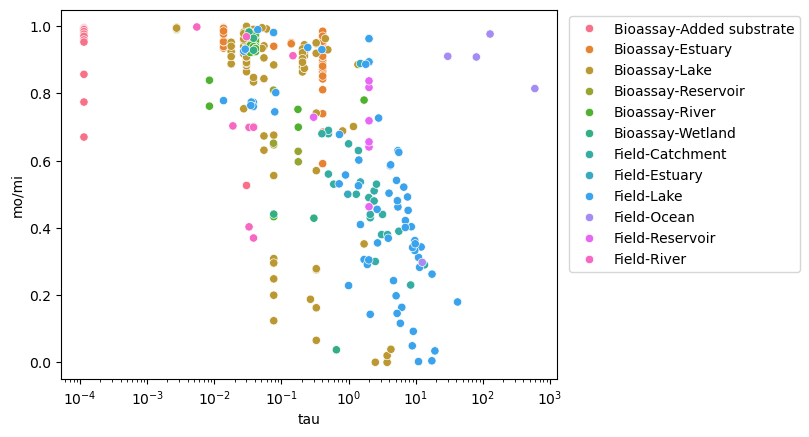

In [3]:
sns.scatterplot(data=df_full.sort_values(by='Type'), x='tau', y='mo_mi', hue='Type')
plt.ylabel('mo/mi')
plt.xlabel('tau')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1))
plt.savefig(r'graphs/catalan_TvsTau_by_ecosys_type.png')

Overall:
* The lakes follow a reasonable negative relationship. The catchments follow suit (these are large Swedish catchments, summing together TOC removal and residence times from lots of lakes within the catchment).
* 4 oceanic points really plot far from the rest.
* Rivers also don't follow the rest. Within just the rivers group, although there are almost no data points, there is no evidence for river retention decreasing with tau:

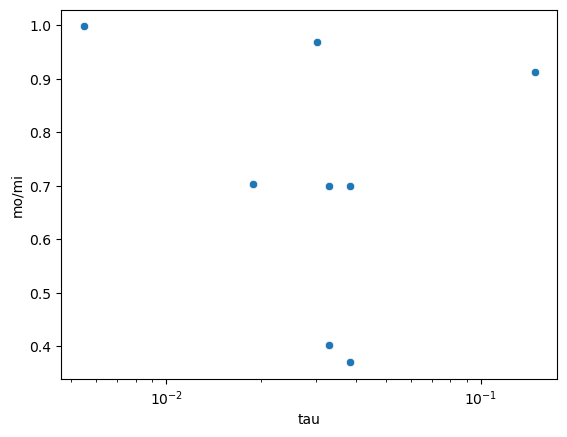

In [210]:
# Plot transmission vs tau for rivers
sns.scatterplot(data=df_natural.loc[df_natural['System']=='River'], x='tau', y='mo_mi')
plt.ylabel('mo/mi')
plt.xlabel('tau')
plt.xscale('log')
plt.savefig('transmission_vs_tau_scatter_rivs.png')

But, these 8 data points only include data from 3 rivers (5 points are from one system, Roaring Brook, McDowell et al. 1976). Other sites are Kryckland (tau=0.005, transmission is high) and Hudson (tau=0.15, retention is still pretty high). So those 5 points with intermediate tau are one river, I assume under different flow conditions, and while perhaps there's a hint of a negative relationship, it's too scattered.

Would need to collect more river C balance data, but it looks a lot like the variability in mo/mi in rivers is too great for a simple relationship with tau. Lakes, reservoirs and estuaries show much less variability, so it's easier to look at this ratio.

# Regressions of ln(k) vs ln(tau) with real vs random data

In [51]:
def regress_obs_and_random(df):
    """
    Perform linear regression on observed and random data, and generate predictions.
    This function takes a DataFrame containing observed and random data, performs 
    linear regression on both sets of data, and generates predictions for plotting. 
    It also prints out the regression results for both the observed and random data.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the following columns:
        - 'tau': Independent variable for regression.
        - 'k': Dependent variable derived from observations.
        - 'random_k': Dependent variable derived from random values.

    Returns:
    pandas.DataFrame: The input DataFrame with added columns for predictions:
        - 'pred_k': Predictions based on observed data.
        - 'pred_random_k': Predictions based on random data.
    statsmodels.regression.linear_model.RegressionResultsWrapper: Regression results for observed data.
    statsmodels.regression.linear_model.RegressionResultsWrapper: Regression results for random data.
    """

    X = sm.add_constant(np.log(df['tau']))
    
    # Regression using k derived from observations
    y = np.log(df['k'])
    model_k = sm.OLS(y, X).fit()

    # Regression using k derived from random M_out/M_in values
    y_random = np.log(df['random_k'])
    model_k_random = sm.OLS(y_random, X).fit()

    # Generate predictions for plotting
    df['pred_lnk'] = model_k.predict(X)
    df['pred_random_lnk'] = model_k_random.predict(X)
    
    # N.B. ignoring back-transformation bias!
    df['pred_k'] = np.exp(model_k.predict(X))
    df['pred_random_k'] = np.exp(model_k_random.predict(X))

    # Print out the regression results
    print("Real data: ", model_k.summary())
    print("\n")
    print("Random data: ", model_k_random.summary())

    return df, model_k, model_k_random


def plot_k_vs_tau_with_random_data(df, x='tau', y_obs='k', y_random='random_k',
                                   y_pred_obs='pred_k', y_pred_random='pred_random_k',
                                   df_type='all_data', logged=True, legend=True, add_label=None):
    """
    Plot observed and random k values against tau with fitted lines.

    This function creates a scatter plot of observed and random k values against tau, 
    along with fitted lines for both datasets. The plot is saved as a PNG file.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the following columns:
        - 'tau': Independent variable for plotting.
        - 'k': Observed dependent variable.
        - 'random_k': Random dependent variable.
        - 'pred_k': Predicted values based on observed data.
        - 'pred_random_k': Predicted values based on random data.
    df_type (str): String for file naming, e.g., "all_data", "bioassay", "field".
    legend (bool, optional): Whether to display the legend. Default is True.
    add_label (str, optional): Additional label to add to the plot. Default is None.

    Returns:
    None
    """
    label_rename_dict = {'FieldModel': 'From observed $M_t/M_0$ (field)',
                         'Bioassay': 'From observed $M_t/M_0$ (bioassay)'}
    
    plt.figure(figsize=(5, 4))

    # Plot random m ratio
    sns.scatterplot(data=df, x=x, y=y_random, marker='x', color='k', label='From random $M_t/M_0$')

    # Plot observed m ratio
    if df_type == 'all_data':
        # Colour points according to whether field or bioassay
        sns.scatterplot(data=df, x=x, y=y_obs, hue='Method')
    else:
        sns.scatterplot(data=df, x=x, y=y_obs, color=sns.color_palette()[1], label='From observed $M_t/M_0$')

    # Plot the fitted lines
    sns.lineplot(data=df, x=x, y=y_pred_random, color='black', lw=2.5, alpha=0.8, label='Fit to random k')
    sns.lineplot(data=df, x=x, y=y_pred_obs, color='red', lw=2.5, alpha=0.8, label='Fit to observed k')

    # Tidy plot
    if logged == True:
        plt.ylabel('ln(k)', size=10)
        plt.xlabel('ln(t)', size=10)  # $\tau$
    else:
        plt.ylabel('k ($\mathrm{yr^{-1}}$)', size=10)
        plt.xlabel((r't (yr)'), size=10)  # $\tau$
        plt.yscale('log')
        plt.xscale('log')

    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.tick_params(axis='both', which='minor', labelsize=8)

    if legend == True:
        plt.legend(fontsize=8, labelspacing=0.1)
        if df_type == 'all_data':
            legend = plt.gca().get_legend()
            for text in legend.get_texts():
                label = text.get_text()
                if label in label_rename_dict:
                    text.set_text(label_rename_dict[label])
            plt.draw()  # Update the plot to show the new legend labels        

    plt.tight_layout()

    if add_label:
        # Add the plot location label to bottom left corner
        plt.text(0.05, 0.05, add_label, transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

    plt.savefig(f'graphs/catalan_data_k_vs_tau_by_method_{df_type}_logs-{logged}.png')
    plt.show()


def check_ci_overlap(model1, model2):
    """
    Check for overlap between the confidence intervals of two regression models.

    This function extracts and prints the confidence intervals for the intercepts and slopes 
    of two regression models. It then checks if the confidence intervals overlap, indicating 
    whether there is a significant difference between the models.

    Parameters:
    model1 (statsmodels.regression.linear_model.RegressionResultsWrapper): The first regression model.
    model2 (statsmodels.regression.linear_model.RegressionResultsWrapper): The second regression model.

    Returns:
    None
    """
    # Extract confidence intervals
    conf_int_1 = model1.conf_int()
    conf_int_2 = model2.conf_int()

    # Print confidence intervals
    print("Confidence intervals for model_k:")
    print(conf_int_1)

    print("\nConfidence intervals for model_k_random:")
    print(conf_int_2)

    # Compare the confidence intervals
    c_conf_int_1 = conf_int_1.iloc[0]
    c_conf_int_2 = conf_int_2.iloc[0]
    slope_conf_int_1 = conf_int_1.iloc[1]
    slope_conf_int_2 = conf_int_2.iloc[1]

    # Check for overlap
    if c_conf_int_1[1] < c_conf_int_2[0] or c_conf_int_1[0] > c_conf_int_2[1]:
        print("\nThe confidence intervals for the intercepts do not overlap, suggesting a significant difference.")
    else:
        print("\nThe confidence intervals for the intercepts overlap, suggesting no significant difference.")

    if slope_conf_int_1[1] < slope_conf_int_2[0] or slope_conf_int_1[0] > slope_conf_int_2[1]:
        print("\nThe confidence intervals for the slopes do not overlap, suggesting a significant difference.")
    else:
        print("\nThe confidence intervals for the slopes overlap, suggesting no significant difference.")

## Full dataset

In [38]:
df, model_k, model_k_random = regress_obs_and_random(df)

Real data:                              OLS Regression Results                            
Dep. Variable:                      k   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     214.2
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           2.57e-37
Time:                        12:02:23   Log-Likelihood:                -497.17
No. Observations:                 315   AIC:                             998.3
Df Residuals:                     313   BIC:                             1006.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9615      0.083    -11.

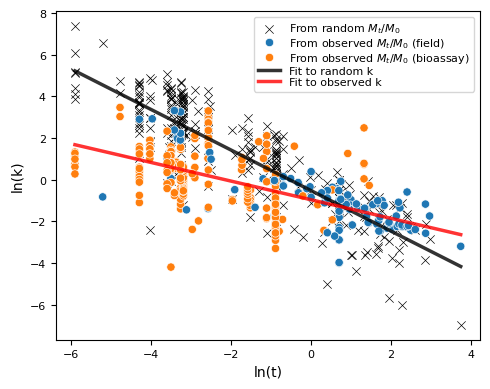

In [52]:
plot_k_vs_tau_with_random_data(df, x='ln_tau', y_obs='ln_k', y_random='ln_random_k',
                               y_pred_obs='pred_lnk', y_pred_random='pred_random_lnk',
                               df_type='all_data', logged=True)

Catalan et al.'s result:

log(k) = -0.45 * log(tau) - 0.96

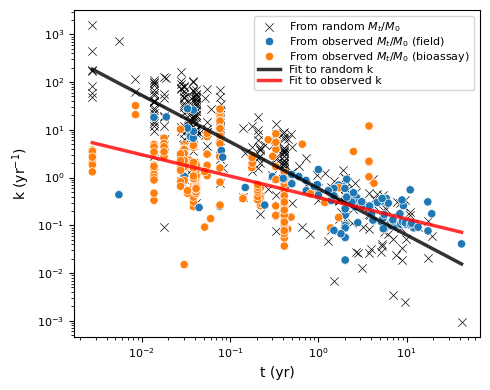

In [54]:
# Check for back-transformation bias. Can't see any.
plot_k_vs_tau_with_random_data(df, df_type='all_data', logged=False)

In [26]:
check_ci_overlap(model_k, model_k_random)

Confidence intervals for model_k:
             0         1
const -1.12468 -0.798223
tau   -0.50804 -0.387630

Confidence intervals for model_k_random:
              0         1
const -0.701076 -0.345858
tau   -1.039860 -0.908841

The confidence intervals for the intercepts do not overlap, suggesting a significant difference.

The confidence intervals for the slopes do not overlap, suggesting a significant difference.


## Split into natural vs bioassay datasets

The difference between random data and real data seems smaller for natural waterbodies than for bioassays. Repeat above analysis for both types separately.

### Natural

In [9]:
df_natural, natural_model_k, natural_model_k_random = regress_obs_and_random(df_natural)

Real data:                              OLS Regression Results                            
Dep. Variable:                      k   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     154.7
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           2.25e-22
Time:                        11:36:20   Log-Likelihood:                -146.96
No. Observations:                 107   AIC:                             297.9
Df Residuals:                     105   BIC:                             303.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8332      0.094     -8.

In [29]:
check_ci_overlap(natural_model_k, natural_model_k_random)

Confidence intervals for model_k:
              0         1
const -1.020292 -0.646176
tau   -0.690285 -0.500457

Confidence intervals for model_k_random:
              0         1
const -0.823695 -0.328201
tau   -1.126435 -0.875020

The confidence intervals for the intercepts overlap, suggesting no significant difference.

The confidence intervals for the slopes do not overlap, suggesting a significant difference.


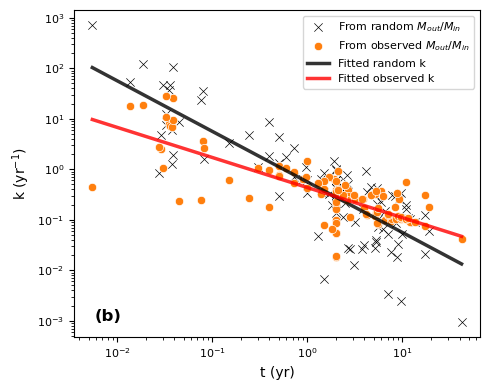

In [11]:
plot_k_vs_tau_with_random_data(df_natural, df_type='field-data', add_label='(b)')

Dropping the bioassay data almost removes the difference between random and real data, though there is still no overlap in the CIs for the slopes (real data: -0.5 to -0.7; random data: -0.77 to -1)

### Bioassay

In [12]:
df_bioassay, bioassay_model_k, bioassay_model_k_random = regress_obs_and_random(df_bioassay)

Real data:                              OLS Regression Results                            
Dep. Variable:                      k   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     42.42
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           5.54e-10
Time:                        11:36:46   Log-Likelihood:                -340.97
No. Observations:                 208   AIC:                             685.9
Df Residuals:                     206   BIC:                             692.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8173      0.175     -4.

In [13]:
check_ci_overlap(bioassay_model_k, bioassay_model_k_random)

Confidence intervals for model_k:
              0         1
const -1.161602 -0.472997
tau   -0.490256 -0.262409

Confidence intervals for model_k_random:
              0         1
const -0.679977  0.025137
tau   -1.028075 -0.794766

The confidence intervals for the intercepts overlap, suggesting no significant difference.

The confidence intervals for the slopes do not overlap, suggesting a significant difference.


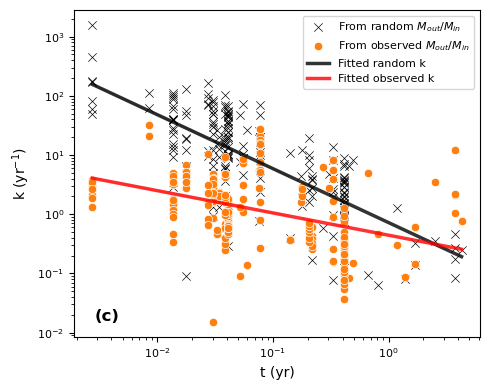

In [14]:
plot_k_vs_tau_with_random_data(df_bioassay, df_type='bioassay', add_label='(c)')

The bioassay-only regression with real data looks very weak. Surprising it has such a low p-value. Maybe due to high density spots not so visible by eye. Look into this by plotting model predictions and the mean

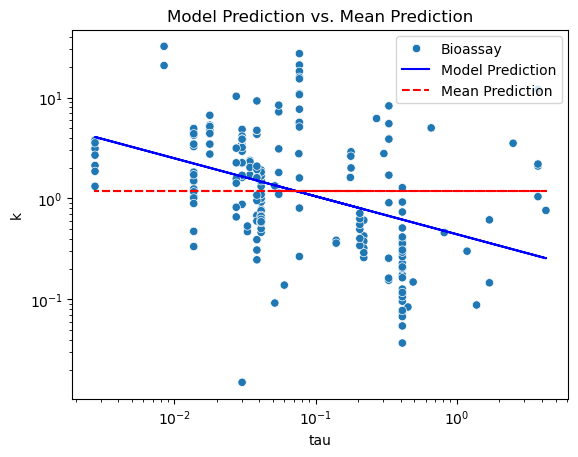

In [203]:
# Compare model predictions with the mean
mean_k = np.mean(np.log(df_bioassay['k']))
df_bioassay['mean_pred_k'] = np.exp(mean_k)
sns.scatterplot(data=df_bioassay, x='tau', y='k', hue='Method')
plt.plot(df_bioassay['tau'], df_bioassay['pred_k'], color='blue', label='Model Prediction')
plt.plot(df_bioassay['tau'], df_bioassay['mean_pred_k'], color='red', linestyle='--', label='Mean Prediction')
plt.xlabel('tau')
plt.ylabel('k')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Model Prediction vs. Mean Prediction')
plt.show()

## Compare regression lines from the full dataset vs field & bioassay data

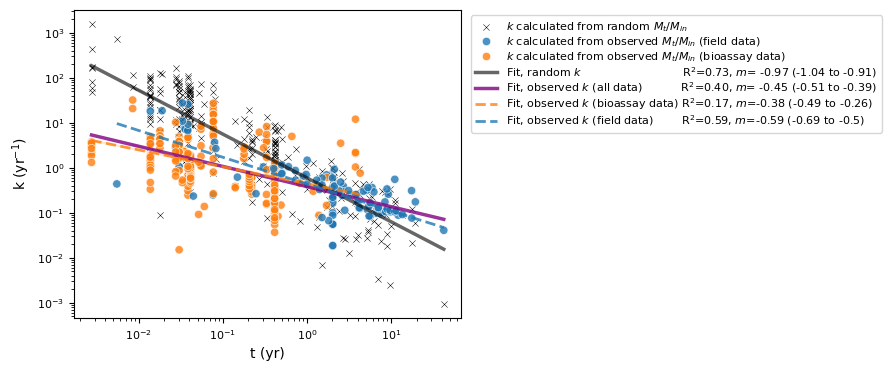

In [204]:
plt.figure(figsize=(5, 4))

# Plot random m ratio
ax = sns.scatterplot(data=df, x='tau', y='random_k', marker='x', s=20, color='k', label='$k$ calculated from random $M_{t}/M_{in}$')

# Plot observed m ratio
sns.scatterplot(ax=ax, data=df, x='tau', y='k', hue='Method', alpha=0.8)

# Plot the fitted lines
sns.lineplot(ax=ax, data=df, x='tau', y='pred_random_k', color='black', lw=2.5, alpha=0.6,
             label='Fit, random $k$                             R$^2$=0.73, $m$= -0.97 (-1.04 to -0.91)')
sns.lineplot(ax=ax, data=df, x='tau', y='pred_k', color='purple', lw=2.5, alpha=0.8,
             label='Fit, observed $k$ (all data)           R$^2$=0.40, $m$= -0.45 (-0.51 to -0.39)')
sns.lineplot(ax=ax, data=df_bioassay, x='tau', y='pred_k', color=sns.color_palette()[1], lw=2, linestyle='--', alpha=0.8,
             label='Fit, observed $k$ (bioassay data) R$^2$=0.17, $m$=-0.38 (-0.49 to -0.26)')
sns.lineplot(ax=ax, data=df_natural, x='tau', y='pred_k', color=sns.color_palette()[0], lw=2, linestyle='--', alpha=0.8,
             label='Fit, observed $k$ (field data)        R$^2$=0.59, $m$=-0.59 (-0.69 to -0.5)')

# Tidy plot
plt.ylabel('k ($\mathrm{yr^{-1}}$)', size=10)
plt.xlabel((r't (yr)'), size=10)  # $\tau$

plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.yscale('log')
plt.xscale('log')

# Sort the legend (override the 'Method' labels)
handles, labels = ax.get_legend_handles_labels()

# Custom labels
field_label = '$k$ calculated from observed $M_{t}/M_{in}$ (field data)'
bioassay_label = '$k$ calculated from observed $M_{t}/M_{in}$ (bioassay data)'
labels[1] = field_label
labels[2] = bioassay_label

# Update legend
legend = plt.legend(handles=handles, labels=labels, fontsize=8, bbox_to_anchor=(1.01, 1), labelspacing=0.1)

# # Add the plot location label to bottom left corner
# plt.text(0.05, 0.05, add_label, transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

plt.savefig(f'graphs/catalan_data_k_vs_tau_by_method.png', bbox_inches='tight')
plt.show()

# Transmission vs residence time

Also plot transmission vs residence time of real data and randomly generated data, to illustrate that the random data misses the real negative relationship which is present in the data.

In [205]:
def predict_transmission(tau):
    pred_T = np.exp(-0.38 * tau ** 0.55)
    return pred_T

df['pred_mo_mi'] = df['tau'].apply(predict_transmission)

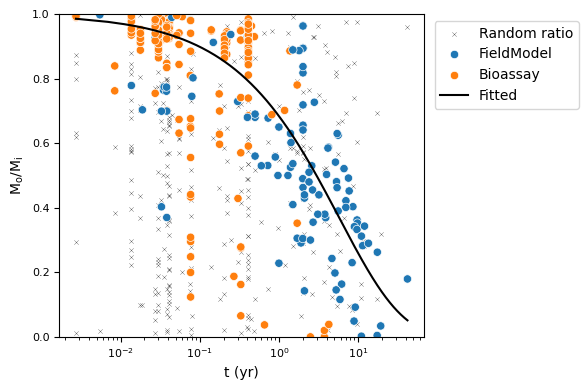

In [206]:
df_plot = df

plt.figure(figsize=(6, 4))

sns.scatterplot(data=df_plot, x='tau', y='random_mo_mi', marker='x', s=10, color='0.3', label='Random ratio')
sns.scatterplot(data=df_plot, x='tau', y='mo_mi', hue='Method')

# Plot Catalan's regression result rearranged in terms of transmission vs tau
taus = np.linspace(df_plot['tau'].min(), df_plot['tau'].max(), 10000)
pred_T = predict_transmission(taus)

plt.plot(taus, pred_T, color='black', label='Fitted')

plt.ylabel('$\mathrm{M_o/M_i}$', size=10)
plt.xlabel((r't (yr)'), size=10)  # $\tau$
plt.ylim(0, 1)
# plt.xlim(0)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

# plt.yscale('log')
plt.xscale('log')

plt.legend(bbox_to_anchor=(1.01, 1), fontsize=10)
plt.tight_layout()
plt.savefig(r'graphs/catalan_TvsTau_by_method_incl_random_T.png')
plt.show()

In [207]:
# R2 of Catalan et al.'s fitted relationship between transmission and tau
r2 = r2_score(df['mo_mi'], df['pred_mo_mi'])

print(f'R-squared: {r2}')

R-squared: 0.5023143223880424


In [211]:
sites_df = df_natural[['System', 'Site']].drop_duplicates().sort_values(by='System')
sites_df.to_csv('data/catalan_unique_sites.csv')
sites_df.head()

,System,Site
246,Catchment,8
247,Catchment,9
248,Catchment,10
249,Catchment,11
250,Catchment,12


To consider:

- Average over sites with duplicate k values and one t value?
- See for the bioassay data that it includes e.g. multiple treatments (e.g. glucose, nutrients,...), so not appropriate to just take a mean. Would need to read the original references to select the most appropriate treatment.